## Accidents corporels de la circulation routière

dataset : https://www.data.gouv.fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/

goal : predict severity of a road accident for the driver in Ile de France

In [812]:
import re

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
import joblib

In [734]:
# Load the files 

year = str(2022)

# Files to load
files = {
    'caract': 'caract-' + year + '.csv',
    'lieux': 'lieux-' + year + '.csv',
    'usagers': 'usagers-' + year + '.csv',
    'vehicules': 'vehicules-' + year + '.csv'
}

# Dictionary to hold the Dataframes
dataframes = {}

# Load each file into a DataFrame
for name, file in files.items(): 
    df = pd.read_csv('data/'+ year + '/' + file, delimiter=';', low_memory=False)
    dataframes[name] = df

#### Explore files

In [735]:
dataframes['caract'].head()

,Accident_Id,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long
0,202200000001,19,10,2022,16:15,1,26,26198,2,3,1,3,TEIL(vieille route du),"44,5594200000","4,7257200000"
1,202200000002,20,10,2022,08:34,1,25,25204,2,3,1,3,Miranda,"46,9258100000","6,3462000000"
2,202200000003,20,10,2022,17:15,1,22,22360,2,6,1,2,ROND POINT DE BREZILLET,"48,4931620000","-2,7604390000"
3,202200000004,20,10,2022,18:00,1,16,16102,2,3,8,6,LOHMEYER (RUE),"45,6926520000","-0,3262900000"
4,202200000005,19,10,2022,11:45,1,13,13103,1,1,1,2,ROUTE DE JEAN MOULIN-RN 538,"43,6755790366","5,0927031775"


In [736]:
dataframes['usagers'].head()

,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202200000001,1 099 700,813 952,A01,1,1,3,1,2008.0,5,2,8,-1,-1,-1,-1
1,202200000001,1 099 701,813 953,B01,1,1,1,1,1948.0,5,1,8,-1,-1,-1,-1
2,202200000002,1 099 698,813 950,B01,1,1,4,1,1988.0,9,1,0,-1,0,0,-1
3,202200000002,1 099 699,813 951,A01,1,1,1,1,1970.0,4,1,0,-1,0,0,-1
4,202200000003,1 099 696,813 948,A01,1,1,1,1,2002.0,0,1,0,-1,-1,-1,-1


In [737]:
dataframes['lieux'].head()

# Remark : duplicates in 'Num_Acc' normal because one accident can happen at an intersection for example

,Num_Acc,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,202200000001,4,TEIL(vieille route du),0,NaN,2,2,0,1,(1),(1),1,NaN,-1,1,0,1,50
1,202200000002,4,NaN,0,NaN,2,2,0,1,(1),(1),1,NaN,-1,1,0,1,50
2,202200000003,3,ROND POINT DE BREZILLET,0,NaN,-1,2,0,1,0,0,1,NaN,-1,1,5,1,50
3,202200000004,4,QUATORZE JUILLET (RUE DU),0,NaN,1,1,0,2,(1),(1),1,NaN,4,1,0,1,30
4,202200000005,3,ROUTE DE JEAN MOULIN-RN 538,0,NaN,2,2,0,1,8,0,1,NaN,-1,1,0,1,80


In [738]:
dataframes['vehicules'].head()

,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,202200000001,813 952,A01,1,2,0,2,1,9,1,NaN
1,202200000001,813 953,B01,1,7,0,2,2,1,1,NaN
2,202200000002,813 950,B01,2,7,0,2,8,15,1,NaN
3,202200000002,813 951,A01,2,10,0,2,1,1,1,NaN
4,202200000003,813 948,A01,2,7,0,2,1,2,1,NaN


In [739]:
# Shapes of the different dataframes
for name, df in dataframes.items():
    print(f'shape of {name} : {df.shape}')

shape of caract : (55302, 15)
shape of lieux : (55302, 18)
shape of usagers : (126662, 16)
shape of vehicules : (94493, 11)


In [740]:
# Information of the different dataframes
for name, df in dataframes.items():
    print(f'info of {name} :')
    print(df.info())
    print('\n')

info of caract :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55302 entries, 0 to 55301
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Accident_Id  55302 non-null  int64 
 1   jour         55302 non-null  int64 
 2   mois         55302 non-null  int64 
 3   an           55302 non-null  int64 
 4   hrmn         55302 non-null  object
 5   lum          55302 non-null  int64 
 6   dep          55302 non-null  object
 7   com          55302 non-null  object
 8   agg          55302 non-null  int64 
 9   int          55302 non-null  int64 
 10  atm          55302 non-null  int64 
 11  col          55302 non-null  int64 
 12  adr          54069 non-null  object
 13  lat          55302 non-null  object
 14  long         55302 non-null  object
dtypes: int64(9), object(6)
memory usage: 6.3+ MB
None


info of lieux :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55302 entries, 0 to 55301
Data columns (total 18 colum

#### Merge into a single dataset

We will use usagers as our base and complete with the other features from the other tables using the primary key feature "Num_Acc" and secondary key "id_vehicule".

In [741]:
if 'Accident_Id' in dataframes['caract'].columns : 
    dataframes['caract'].rename(columns={'Accident_Id': 'Num_Acc'}, inplace=True)

In [742]:
# Initialize the dataframe to be merged using usagers as base
df = dataframes['usagers']

# Merge with accident caracteristics 
df = df.merge(dataframes['caract'], on='Num_Acc', how='left')

# Merge with accident locations
df = df.merge(dataframes['lieux'], on='Num_Acc', how='left')

# Merge with vehicle information
df = df.merge(dataframes['vehicules'], on=['Num_Acc', 'id_vehicule'], how='left')

# Merged dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126662 entries, 0 to 126661
Data columns (total 56 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      126662 non-null  int64  
 1   id_usager    126662 non-null  object 
 2   id_vehicule  126662 non-null  object 
 3   num_veh_x    126662 non-null  object 
 4   place        126662 non-null  int64  
 5   catu         126662 non-null  int64  
 6   grav         126662 non-null  int64  
 7   sexe         126662 non-null  int64  
 8   an_nais      123788 non-null  float64
 9   trajet       126662 non-null  int64  
 10  secu1        126662 non-null  int64  
 11  secu2        126662 non-null  int64  
 12  secu3        126662 non-null  int64  
 13  locp         126662 non-null  int64  
 14  actp         126662 non-null  object 
 15  etatp        126662 non-null  int64  
 16  jour         126662 non-null  int64  
 17  mois         126662 non-null  int64  
 18  an           126662 non-

In [743]:
# Remove duplicates 
df = df.drop_duplicates(subset=['Num_Acc', 'id_usager'])
df.shape

(126662, 56)

In [744]:
# Save the merged dataframe  
df.to_csv('data/' + year + '/' + 'accidents_' + year + '.csv', index=False)

#### Filter to Ile de France

In [745]:
# Load the dataframe
df = pd.read_csv('data/' + year + '/' + 'accidents_' + year + '.csv', low_memory=False)

In [746]:
# All departments
df['dep'].unique()

array(['26', '25', '22', '16', '13', '12', '10', '09', '06', '03', '02',
       '75', '94', '93', '92', '76', '68', '972', '63', '62', '51', '2B',
       '65', '33', '71', '89', '61', '29', '38', '14', '60', '45', '73',
       '53', '24', '27', '17', '48', '973', '77', '67', '988', '08', '56',
       '69', '91', '78', '64', '59', '49', '42', '37', '34', '32', '31',
       '11', '35', '47', '86', '01', '74', '79', '2A', '46', '39', '72',
       '05', '18', '19', '971', '987', '66', '84', '85', '95', '57', '54',
       '52', '50', '44', '974', '83', '28', '15', '07', '80', '30', '41',
       '82', '55', '43', '40', '04', '986', '88', '36', '87', '21', '976',
       '81', '58', '70', '90', '23', '977', '978', '975'], dtype=object)

In [747]:
# Departments in Ile de France

dep = 'idf'

dep_idf = ['75', '77', '78', '91', '92', '93', '94', '95']

# Filter
df_idf = df[df['dep'].isin(dep_idf)].copy()
df_idf.shape

(37427, 56)

In [748]:
# Remove the department feature
df_idf = df_idf.drop(columns=['dep'])

In [749]:
# Save the filtered dataframe
df_idf.to_csv('data/' + year + '/' + 'accidents_' + year + '_' + dep + '.csv', index=False)

#### Data cleaning & Preprocessing

In [750]:
# Load the filtered dataframe
df = pd.read_csv('data/' + year + '/' + 'accidents_' + year + '_' + dep + '.csv', low_memory=False)
df.keys()

Index(['Num_Acc', 'id_usager', 'id_vehicule', 'num_veh_x', 'place', 'catu',
       'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2', 'secu3', 'locp',
       'actp', 'etatp', 'jour', 'mois', 'an', 'hrmn', 'lum', 'com', 'agg',
       'int', 'atm', 'col', 'adr', 'lat', 'long', 'catr', 'voie', 'v1', 'v2',
       'circ', 'nbv', 'vosp', 'prof', 'pr', 'pr1', 'plan', 'lartpc', 'larrout',
       'surf', 'infra', 'situ', 'vma', 'num_veh_y', 'senc', 'catv', 'obs',
       'obsm', 'choc', 'manv', 'motor', 'occutc'],
      dtype='object')

In [751]:
# Remove id columns
df = df.drop(columns=['Num_Acc', 'id_usager', 'id_vehicule','num_veh_x','num_veh_y'])
df.keys()

Index(['place', 'catu', 'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2',
       'secu3', 'locp', 'actp', 'etatp', 'jour', 'mois', 'an', 'hrmn', 'lum',
       'com', 'agg', 'int', 'atm', 'col', 'adr', 'lat', 'long', 'catr', 'voie',
       'v1', 'v2', 'circ', 'nbv', 'vosp', 'prof', 'pr', 'pr1', 'plan',
       'lartpc', 'larrout', 'surf', 'infra', 'situ', 'vma', 'senc', 'catv',
       'obs', 'obsm', 'choc', 'manv', 'motor', 'occutc'],
      dtype='object')

In [752]:
# Spatial features

# replace comma with dot for decimal and convert to float
df['lat'] = df['lat'].astype(str).str.replace(',', '.')
df['long'] = df['long'].astype(str).str.replace(',', '.')

# Convert to float
df['lat'] = df['lat'].astype(float)
df['long'] = df['long'].astype(float)

# Remove redundants location labels
df = df.drop(columns=['adr','com','pr','pr1','voie','v1','v2'])
df.keys()

Index(['place', 'catu', 'grav', 'sexe', 'an_nais', 'trajet', 'secu1', 'secu2',
       'secu3', 'locp', 'actp', 'etatp', 'jour', 'mois', 'an', 'hrmn', 'lum',
       'agg', 'int', 'atm', 'col', 'lat', 'long', 'catr', 'circ', 'nbv',
       'vosp', 'prof', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ',
       'vma', 'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor',
       'occutc'],
      dtype='object')

In [753]:
# Temporal features 

# Ensure day and month are zero-padded
df['jour_str'] = df['jour'].astype(str).str.zfill(2)
df['mois_str'] = df['mois'].astype(str).str.zfill(2)
df['an_str'] = df['an'].astype(str)

# Convert date to datetime 
# hrmn is already in 'HH:MM' format
date_string = df['an_str'] + '-' + df['mois_str'] + '-' + df['jour_str'] + ' ' + df['hrmn']
df['datetime'] = pd.to_datetime(date_string, format='%Y-%m-%d %H:%M')

# Extract features
df['Hour'] = df['datetime'].dt.hour
df['DayOfWeek'] = df['datetime'].dt.dayofweek 
df['Month'] = df['datetime'].dt.month

# Change person birth to his age when the accident happened
df['Age'] = float(year) - df['an_nais']

# Remove temporary features 
df = df.drop(columns=['jour_str', 'mois_str', 'an_str', 'an', 'mois', 'jour', 'hrmn', 'datetime', 'an_nais'])
df.keys()

Index(['place', 'catu', 'grav', 'sexe', 'trajet', 'secu1', 'secu2', 'secu3',
       'locp', 'actp', 'etatp', 'lum', 'agg', 'int', 'atm', 'col', 'lat',
       'long', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'lartpc',
       'larrout', 'surf', 'infra', 'situ', 'vma', 'senc', 'catv', 'obs',
       'obsm', 'choc', 'manv', 'motor', 'occutc', 'Hour', 'DayOfWeek', 'Month',
       'Age'],
      dtype='object')

In [754]:
# Values of grav 
print(df['grav'].value_counts())

# Remove the samples where gravity is not specified
df = df[df['grav'] != -1].copy()

grav
 4    17757
 1    17401
 3     1906
 2      281
-1       82
Name: count, dtype: int64


In [755]:
# We will focus on drivers only
df = df[df['catu'] == 1].copy()

# Remove features linked to pedestrians and catu
df = df.drop(columns=['actp','locp','etatp','catu'])

In [756]:
# Check which columns contains -1 that means not specified and the percentage
bad_columns = {}

for column in df.columns:
    count = df[column].isin([-1,'-1', ' -1']).sum()
    if count > 0:
        percentage = (count / len(df)) * 100
        bad_columns[column] = percentage

sorted_bad_columns = sorted(bad_columns.items(), key=lambda item: item[1], reverse=True)
for column, percentage in sorted_bad_columns:
    print(f"- {column}: {percentage:.2f} %")

# We will keep secu2 as it can be useful if we know they wear more secure items

- secu3: 99.61 %
- larrout: 99.50 %
- secu2: 11.37 %
- circ: 6.08 %
- trajet: 4.17 %
- secu1: 4.10 %
- sexe: 4.07 %
- infra: 2.97 %
- nbv: 0.59 %
- vma: 0.51 %
- senc: 0.51 %
- vosp: 0.28 %
- motor: 0.11 %
- obs: 0.05 %
- obsm: 0.04 %
- col: 0.02 %
- choc: 0.02 %
- manv: 0.02 %
- int: 0.02 %
- situ: 0.01 %
- place: 0.01 %
- surf: 0.01 %


In [757]:
# Remove secu3 and larrout
df = df.drop(columns=['secu3', 'larrout'])

In [758]:
df.shape

(29029, 36)

In [759]:
# Missing values
print(df.isnull().sum())

place            0
grav             0
sexe             0
trajet           0
secu1            0
secu2            0
lum              0
agg              0
int              0
atm              0
col              0
lat              0
long             0
catr             0
circ             0
nbv              0
vosp             0
prof             0
plan             0
lartpc       29029
surf             0
infra            0
situ             0
vma              0
senc             0
catv             0
obs              0
obsm             0
choc             0
manv             0
motor            0
occutc       28699
Hour             0
DayOfWeek        0
Month            0
Age           1253
dtype: int64


In [760]:
# Drop columns with too many missing values
df = df.drop(columns=['lartpc', 'occutc'])

# Drop samples with missing values
df = df.dropna(subset=['Age'])

In [761]:
print(df.shape)
print(df.isnull().sum())

(27776, 34)
place        0
grav         0
sexe         0
trajet       0
secu1        0
secu2        0
lum          0
agg          0
int          0
atm          0
col          0
lat          0
long         0
catr         0
circ         0
nbv          0
vosp         0
prof         0
plan         0
surf         0
infra        0
situ         0
vma          0
senc         0
catv         0
obs          0
obsm         0
choc         0
manv         0
motor        0
Hour         0
DayOfWeek    0
Month        0
Age          0
dtype: int64


In [762]:
df.keys()

Index(['place', 'grav', 'sexe', 'trajet', 'secu1', 'secu2', 'lum', 'agg',
       'int', 'atm', 'col', 'lat', 'long', 'catr', 'circ', 'nbv', 'vosp',
       'prof', 'plan', 'surf', 'infra', 'situ', 'vma', 'senc', 'catv', 'obs',
       'obsm', 'choc', 'manv', 'motor', 'Hour', 'DayOfWeek', 'Month', 'Age'],
      dtype='object')

In [763]:
df.to_csv('data/' + year + '/' + 'accidents_' + year + '_' + dep + '_cleaned.csv', index=False)

#### Merge datasets from different years

In [764]:
# Initialize
years = ['2022', '2023']

dataframes = []

# Load and append to dataframes
for year in years : 
    df = pd.read_csv('data/' + year + '/' + 'accidents_' + year + '_' + dep + '_cleaned.csv', low_memory=False)
    dataframes.append(df)

# Concatenate all years
df = pd.concat(dataframes, ignore_index=True)

print(f'shape : {df.shape}')
print(f'gravity counts : \n {df["grav"].value_counts()}')

# Save the merged file
df.to_csv('data/accidents_idf_2022_2023_cleaned.csv', index=False)

shape : (54959, 34)
gravity counts : 
 grav
1    27939
4    24130
3     2556
2      334
Name: count, dtype: int64


#### Data exploration

In [765]:
df = pd.read_csv('data/accidents_idf_2022_2023_cleaned.csv', low_memory=False)

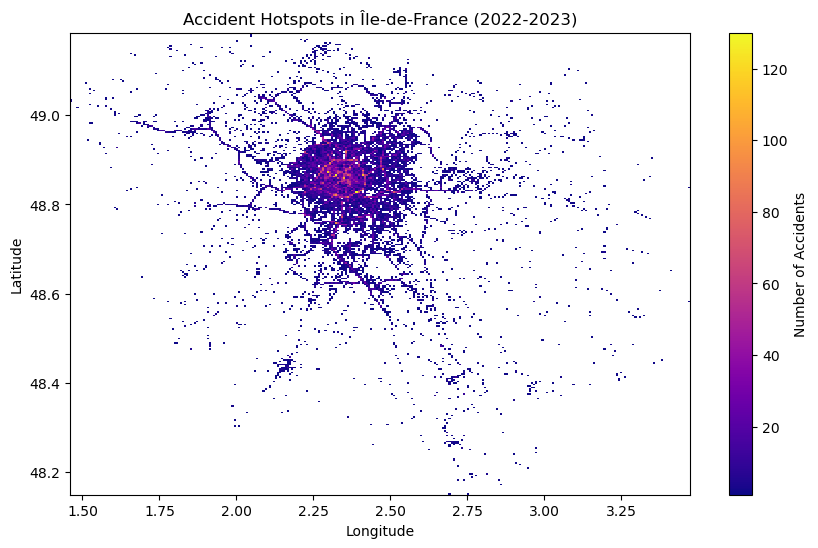

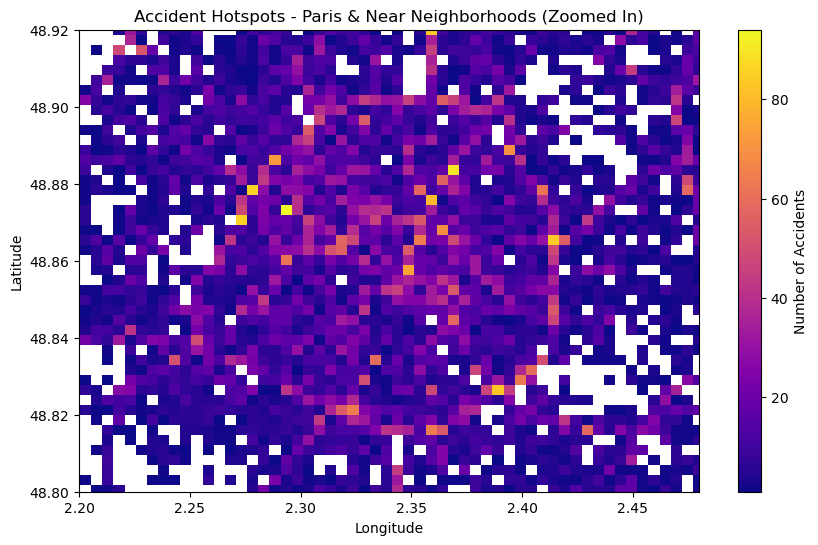

In [766]:
# Accidents hotspots visualization 

# All Ile de France
plt.figure(figsize=(10, 6))
plt.hist2d(df['long'], df['lat'], bins=(300, 300), cmap='plasma', cmin=1) # cmin=1 ignores empty bins
plt.colorbar(label='Number of Accidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Accident Hotspots in Île-de-France (2022-2023)')
plt.show()

# Paris
paris_lon_min = 2.20
paris_lon_max = 2.48
paris_lat_min = 48.8
paris_lat_max = 48.92

plt.figure(figsize=(10, 6))
plt.hist2d(df['long'], df['lat'], bins=(400, 400), cmap='plasma', cmin=1)
plt.colorbar(label='Number of Accidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Accident Hotspots - Paris & Near Neighborhoods (Zoomed In)')
plt.xlim(paris_lon_min, paris_lon_max)
plt.ylim(paris_lat_min, paris_lat_max)
plt.show()

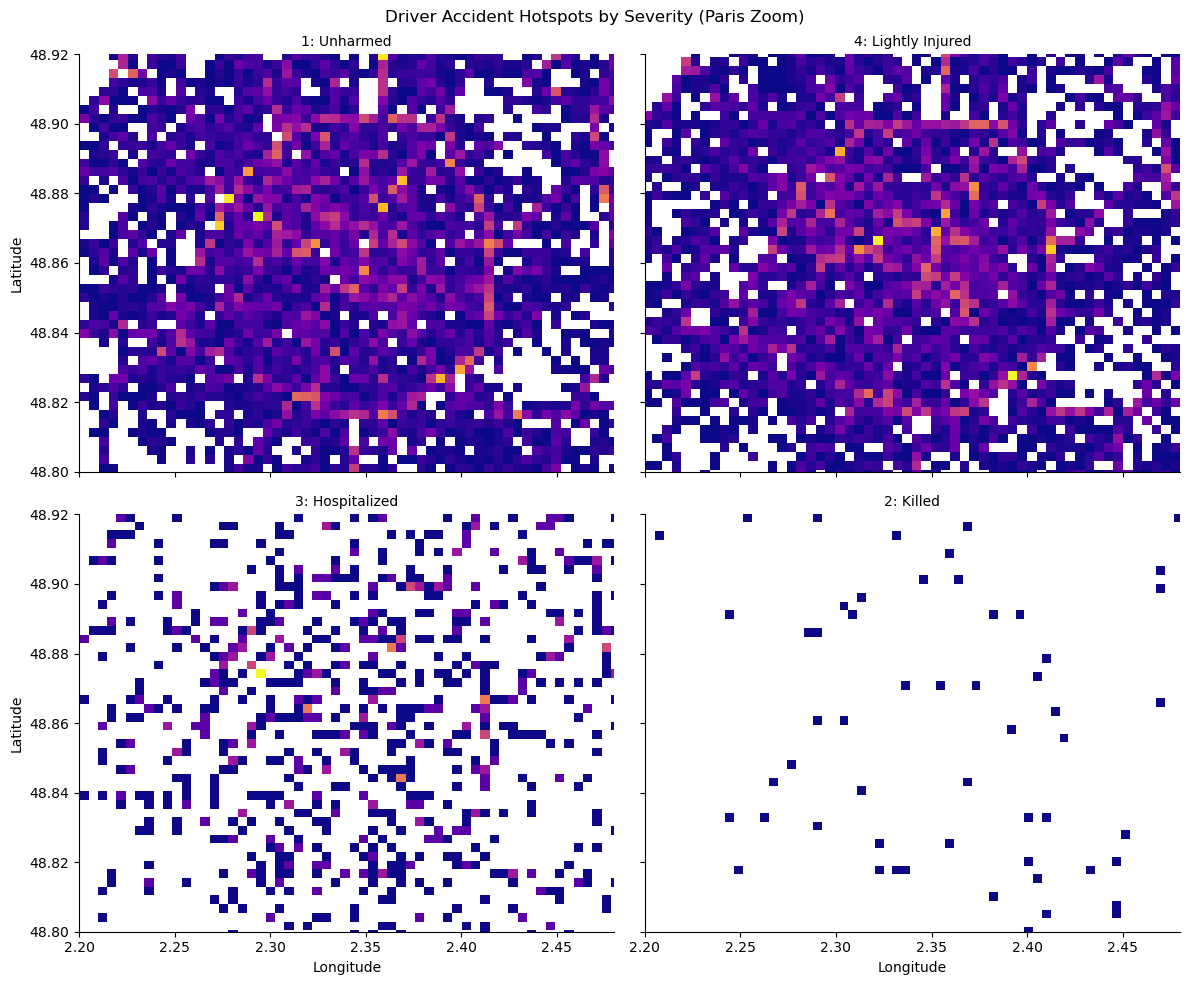

In [767]:
# Labels name
def map_gravity_names(grav_code):
    if grav_code == 1:
        return '1: Unharmed'
    if grav_code == 2:
        return '2: Killed'
    if grav_code == 3:
        return '3: Hospitalized'
    if grav_code == 4:
        return '4: Lightly Injured'
    return 'Unknown'

df['gravity_label'] = df['grav'].apply(map_gravity_names)

# seaborn's FacetGrid
g = sns.FacetGrid(
    df, 
    col="gravity_label", 
    col_wrap=2,  
    col_order=['1: Unharmed', '4: Lightly Injured', '3: Hospitalized', '2: Killed'],
    height=5,   
    aspect=1.2    # Aspect ratio is 1 (square plots)
)

# Define a function to plot a 2D histogram on each facet
# --- FIXED THE FUNCTION SIGNATURE ---
def plot_hist2d(x, y, **kwargs):
    # Get the current axes
    ax = plt.gca()
    # Add hist2d plot to the axes
    # We remove 'color' and 'label' from kwargs as hist2d doesn't expect them in this way
    # and they are passed by FacetGrid.
    kwargs_cleaned = kwargs.copy()
    kwargs_cleaned.pop('color', None)
    kwargs_cleaned.pop('label', None)
    
    ax.hist2d(x, y, bins=(400, 400), cmap='plasma', cmin=1, **kwargs_cleaned)

# Map the hist2d function to the grid
g.map(plot_hist2d, "long", "lat")

# Set titles and limits
g.set_titles("{col_name}")
g.set_axis_labels("Longitude", "Latitude")
# Set common axis limits for comparison
g.set(xlim=(paris_lon_min, paris_lon_max), ylim=(paris_lat_min, paris_lat_max)) # Paris + Périphérique zoom
g.fig.suptitle('Driver Accident Hotspots by Severity (Paris Zoom)')
g.fig.tight_layout()


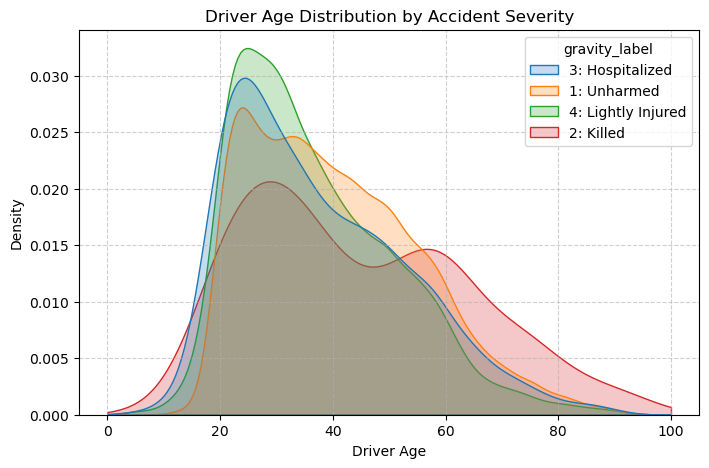

In [768]:
# Age distribution
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='Age', hue='gravity_label', fill=True, common_norm=False, clip=(0, 100))
plt.title('Driver Age Distribution by Accident Severity')
plt.xlabel('Driver Age')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

<Figure size 1400x700 with 0 Axes>

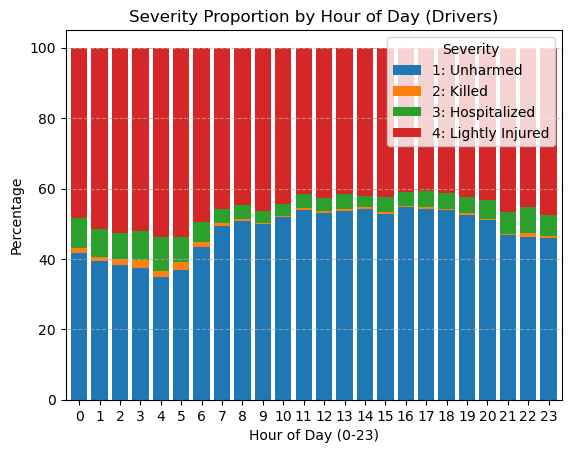

In [769]:
# Hour distribution
hour_ct = pd.crosstab(df['Hour'], df['gravity_label'], normalize='index') * 100
plt.figure(figsize=(14, 7))
hour_ct.plot(kind='bar', stacked=True, width=0.8)
plt.title('Severity Proportion by Hour of Day (Drivers)')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Severity')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Figure size 1400x700 with 0 Axes>

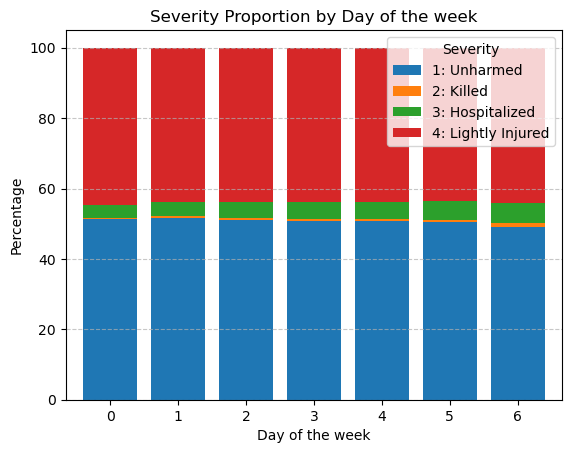

In [770]:
# Day of the week distribution
day_ct = pd.crosstab(df['DayOfWeek'], df['gravity_label'], normalize='index') * 100
plt.figure(figsize=(14, 7))
day_ct.plot(kind='bar', stacked=True, width=0.8)
plt.title('Severity Proportion by Day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Severity')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Figure size 1400x700 with 0 Axes>

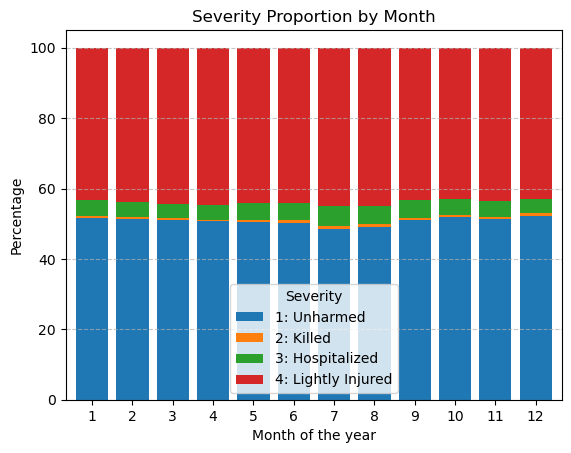

In [771]:
# Month distribution
month_ct = pd.crosstab(df['Month'], df['gravity_label'], normalize='index') * 100
plt.figure(figsize=(14, 7))
month_ct.plot(kind='bar', stacked=True, width=0.8)
plt.title('Severity Proportion by Month')
plt.xlabel('Month of the year')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Severity')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Figure size 2000x800 with 0 Axes>

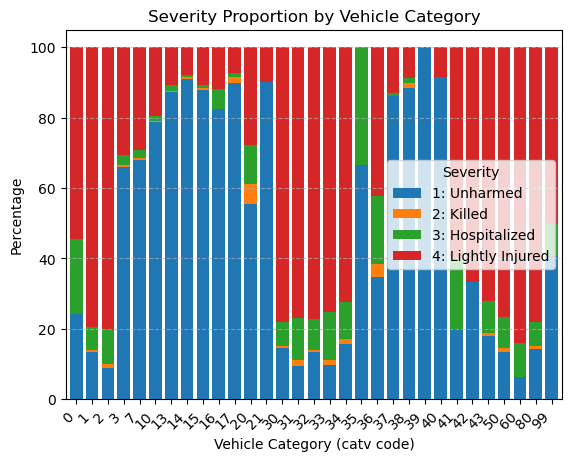

In [772]:
# Vehicule category distribution

# Filter out -1
df_catv = df[df['catv'] != -1]

# Normalized crosstab
catv_ct = pd.crosstab(df_catv['catv'], df_catv['gravity_label'], normalize='index') * 100
plt.figure(figsize=(20, 8))
catv_ct.plot(kind='bar', stacked=True, width=0.8)
plt.title('Severity Proportion by Vehicle Category')
plt.xlabel('Vehicle Category (catv code)')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Severity')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Text(0.5, 1.0, 'Feature Correlation Heatmap (Drivers Only)')

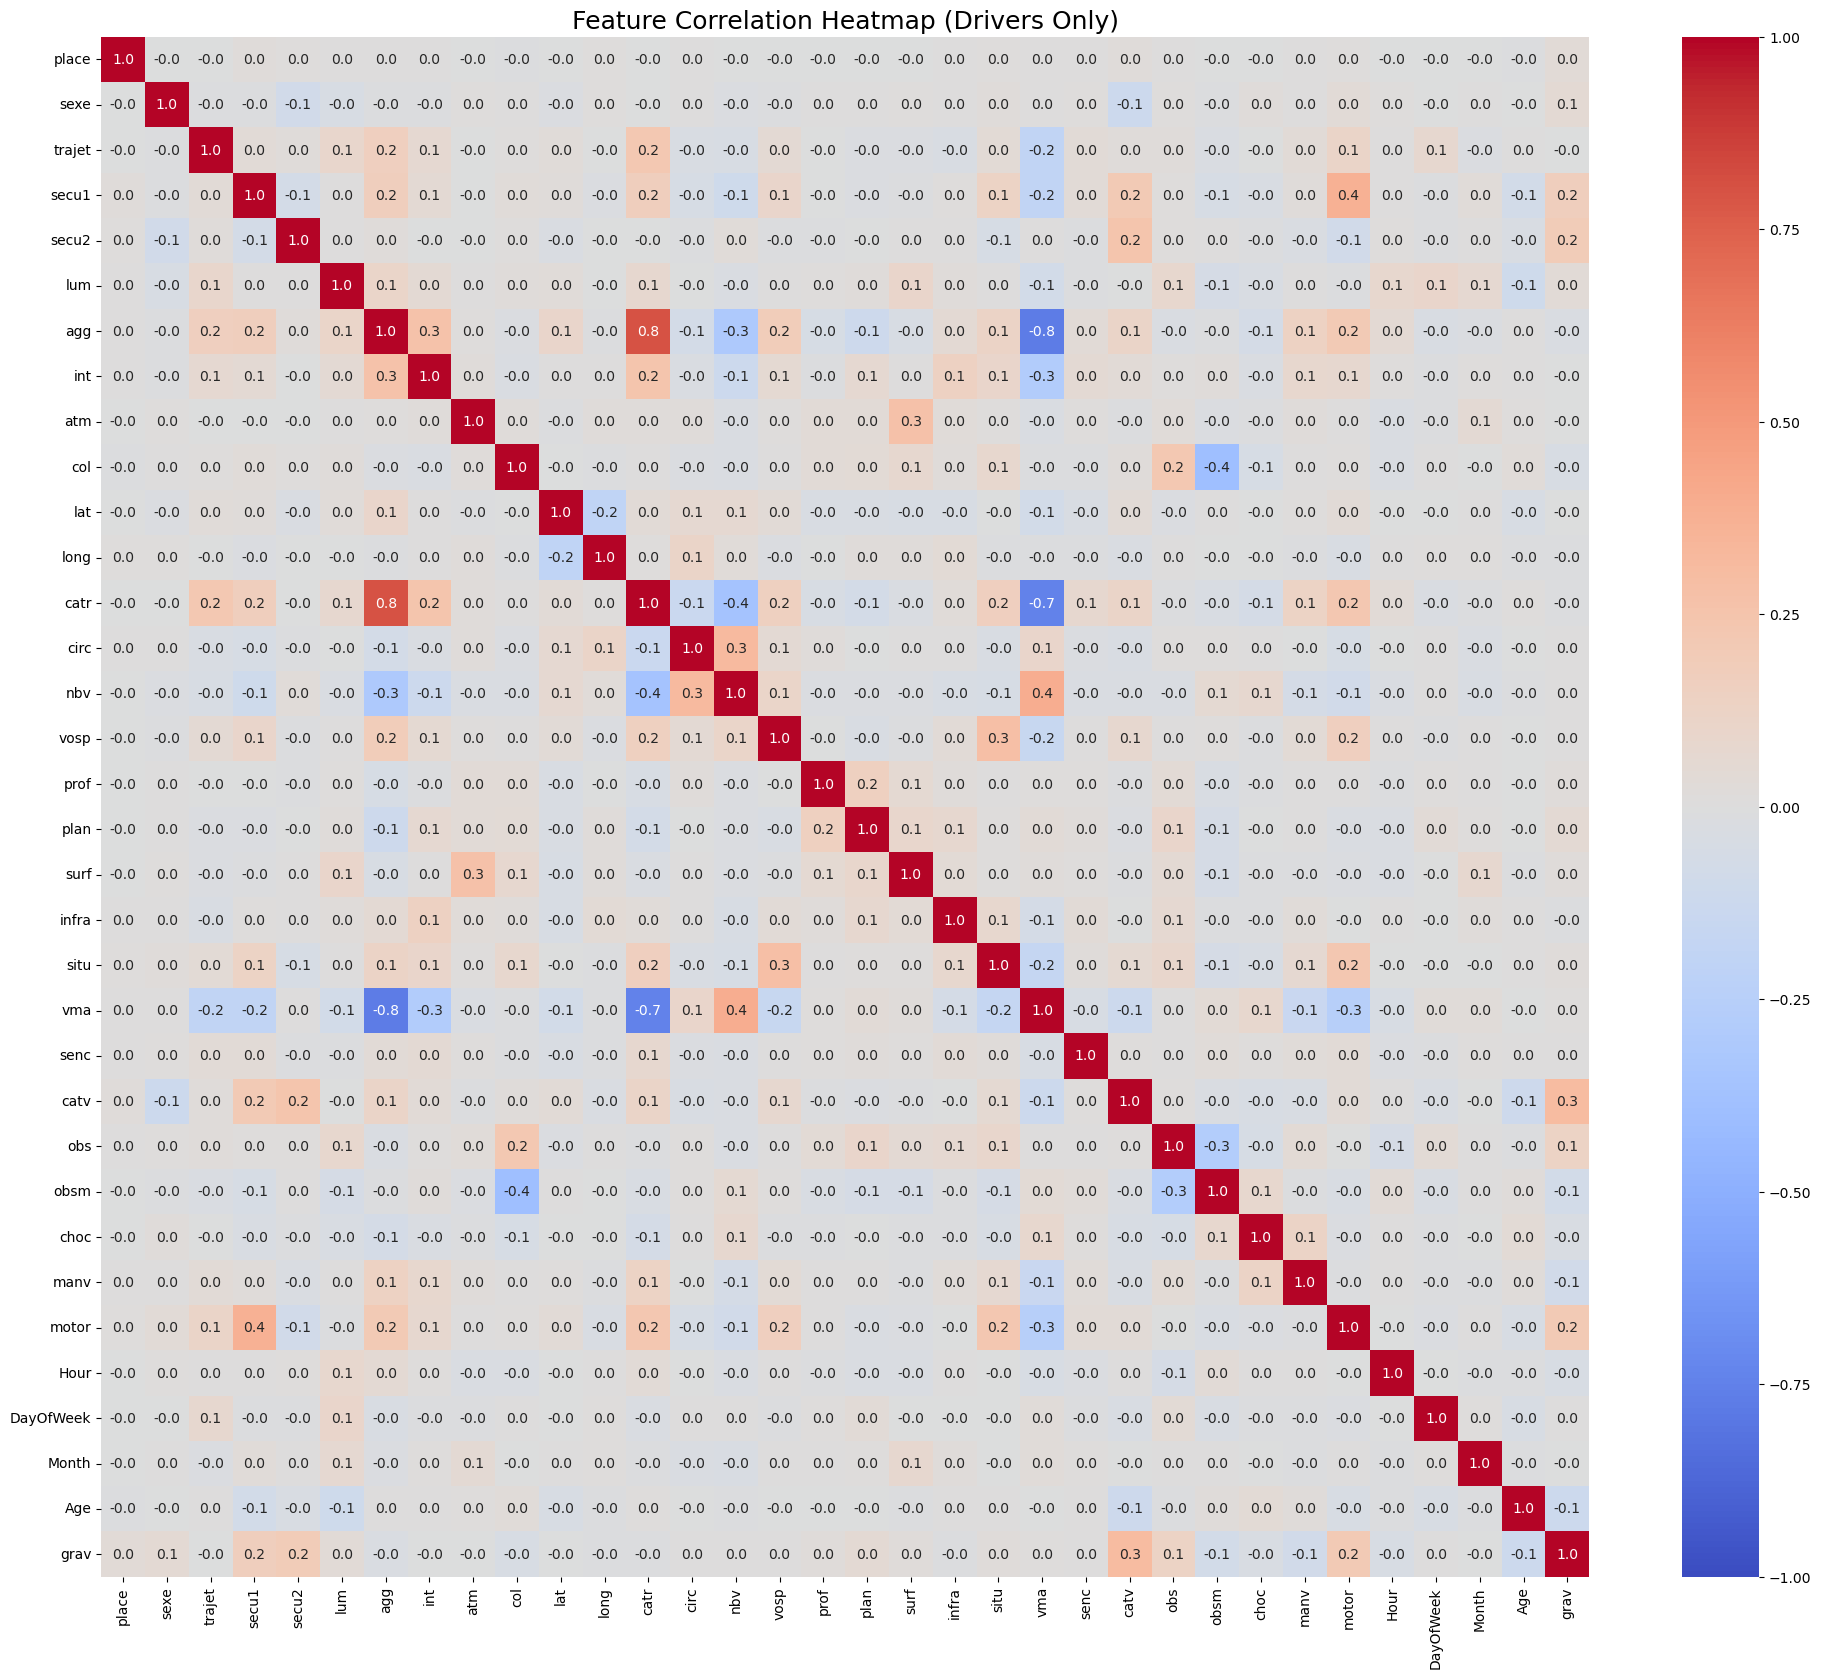

In [773]:
# Feature to feature correlation

# 1. Define our final 33 features + 1 target
final_features = ['place', 'sexe', 'trajet', 'secu1', 'secu2', 'lum', 'agg', 
                  'int', 'atm', 'col', 'lat', 'long', 'catr', 'circ', 'nbv', 'vosp', 
                  'prof', 'plan', 'surf', 'infra', 'situ', 'vma', 'senc', 'catv', 
                  'obs', 'obsm', 'choc', 'manv', 'motor', 'Hour', 'DayOfWeek', 
                  'Month', 'Age']

target = 'grav'
cols_to_analyze = final_features + [target]

# convert ALL to numeric (forcing -1 strings, etc. to NaN)
df_corr = df[cols_to_analyze].copy()
for col in df_corr.columns:
    df_corr[col] = pd.to_numeric(df_corr[col], errors='coerce')

# Plot Feature-to-Feature Heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(corr_matrix, annot=True, fmt='.1f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap (Drivers Only)', fontsize=18)

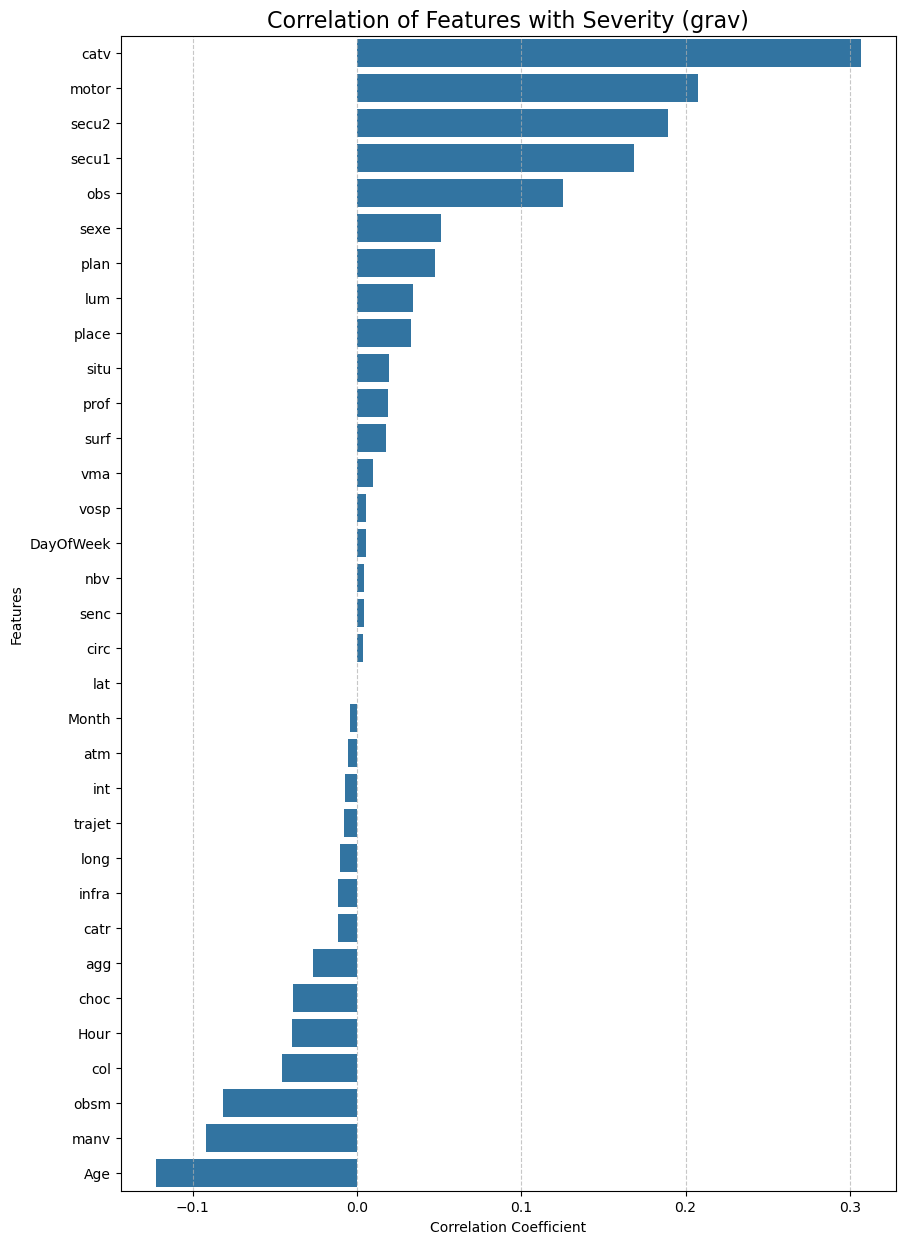

In [774]:
# Feature-to-Target Correlation
corr_with_grav = corr_matrix['grav'].drop('grav')
corr_with_grav = corr_with_grav.sort_values(ascending=False)

plt.figure(figsize=(10, 15))
sns.barplot(x=corr_with_grav.values, y=corr_with_grav.index)
plt.title('Correlation of Features with Severity (grav)', fontsize=16)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### Feature engineering

In [792]:
df = pd.read_csv('data/accidents_idf_2022_2023_cleaned.csv', low_memory=False)
df.keys()

Index(['place', 'grav', 'sexe', 'trajet', 'secu1', 'secu2', 'lum', 'agg',
       'int', 'atm', 'col', 'lat', 'long', 'catr', 'circ', 'nbv', 'vosp',
       'prof', 'plan', 'surf', 'infra', 'situ', 'vma', 'senc', 'catv', 'obs',
       'obsm', 'choc', 'manv', 'motor', 'Hour', 'DayOfWeek', 'Month', 'Age'],
      dtype='object')

In [793]:
# Class imbalance
df['grav'].value_counts()

grav
1    27939
4    24130
3     2556
2      334
Name: count, dtype: int64

In [794]:
# We will merge killed and hospitalized to severe and the others as light
def map_severity(grav_code):
    if grav_code == 2 or grav_code == 3:
        return 'Severe'  # Killed or Hospitalized
    elif grav_code == 4 or grav_code == 1:
        return 'Light'   # Lightly injured or Unharmed
    return 'Unknown' # Will be filtered out later

df['Severity'] = df['grav'].apply(map_severity)

df['Severity'].value_counts()

Severity
Light     52069
Severe     2890
Name: count, dtype: int64

In [795]:
df.keys()

Index(['place', 'grav', 'sexe', 'trajet', 'secu1', 'secu2', 'lum', 'agg',
       'int', 'atm', 'col', 'lat', 'long', 'catr', 'circ', 'nbv', 'vosp',
       'prof', 'plan', 'surf', 'infra', 'situ', 'vma', 'senc', 'catv', 'obs',
       'obsm', 'choc', 'manv', 'motor', 'Hour', 'DayOfWeek', 'Month', 'Age',
       'Severity'],
      dtype='object')

In [796]:
# Numerical features
numerical_features = ['lat', 'long', 'Age', 'Hour', 'DayOfWeek', 'Month']

# Categorical features
categorical_features = [
    'place', 'sexe', 'trajet', 'secu1', 'secu2', 'lum', 'agg', 
    'int', 'atm', 'col', 'catr', 'circ', 'nbv', 'vosp', 
    'prof', 'plan', 'surf', 'infra', 'situ', 'vma', 'senc', 'catv', 
    'obs', 'obsm', 'choc', 'manv', 'motor'
]

In [797]:
# Split target and features
X = df.drop(columns=['grav','Severity'])
y = df['Severity']

In [798]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Split data: {len(y_train)} train, {len(y_test)} test samples.")
print(f"Test set 'Severity' distribution (real-world):\n{y_test.value_counts()}")

Split data: 43967 train, 10992 test samples.
Test set 'Severity' distribution (real-world):
Severity
Light     10414
Severe      578
Name: count, dtype: int64


In [799]:
# Undersampling on the training set because of class imbalance
train_data = pd.concat([X_train, y_train], axis=1)
severe_samples = train_data[train_data['Severity'] == 'Severe']
light_samples = train_data[train_data['Severity'] == 'Light']

# Undersample the non severe class
n_severe = len(severe_samples)
ratio = 1.1
light_samples_undersampled = light_samples.sample(n=int(n_severe*ratio), random_state=42)

# New balanced training set
train_data_balanced = pd.concat([severe_samples, light_samples_undersampled])
X_train_balanced = train_data_balanced.drop('Severity', axis=1)
y_train_balanced = train_data_balanced['Severity']
print(f"New distribution:\n{y_train_balanced.value_counts()}")

New distribution:
Severity
Light     2543
Severe    2312
Name: count, dtype: int64


In [800]:
# Preprocessing pipeline

# Standardize numerical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# One-hot encoding categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # 'ignore' handles new categories at predict time
])

# Combine both 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' 
)

In [801]:
# Full pipeline

model_pipeline_v2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1))
])

In [802]:
# Train model
model_pipeline_v2.fit(X_train_balanced, y_train_balanced)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

      Severe       0.14      0.76      0.24       578
       Light       0.98      0.74      0.85     10414

    accuracy                           0.75     10992
   macro avg       0.56      0.75      0.54     10992
weighted avg       0.94      0.75      0.82     10992



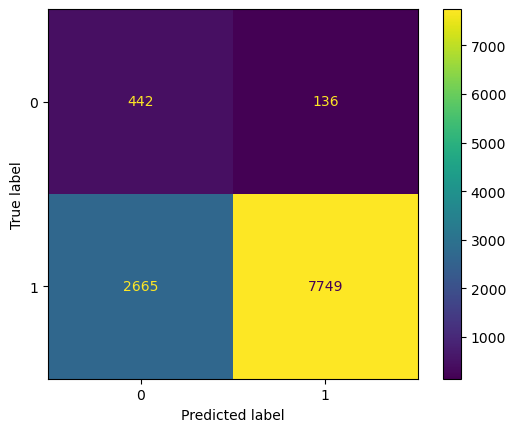

In [814]:
# Evaluate model on test set
y_pred_v2 = model_pipeline_v2.predict(X_test)
print(classification_report(y_test, y_pred_v2, labels=['Severe', 'Light']))

# Confusion matrix
cm = confusion_matrix(y_test,y_pred_v2, labels=['Severe', 'Light'])
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [810]:
# Save model 
joblib.dump(model_pipeline_v2, '.\\models\\rf_model.joblib')

['.\\models\\rf_model.joblib']